# *Monod* model selection: fit to liver cell types

In the current notebook, we run the *Monod* inference pipeline on two pre-clustered human liver datasets, disaggregated into pericentral, periportal, and interzonal hepatocytes, using a common set of 3,000 genes and four models (bursty, extrinsic, delayed-splicing, and delayed-efflux).

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [3]:
dataset_meta = ['sc','sn']

cluster_names = ['CentralHep','PortalHep','InterHep']
dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names]

transcriptome_filepath = '../seq-cme-technoise/polyA_ref/gg_200525_genome_polyA_cum_3'
attribute_names=[('unspliced','spliced'),'gene_name','barcode']



In [4]:
loom_filepaths = ['/home/ggorin/count_data/loom_liver_kb/liver_c72_'+dataset_meta[0]+'.loom' ]*len(cluster_names) + \
                 ['/home/ggorin/count_data/loom_liver_kb/liver_c72_'+dataset_meta[1]+'.loom' ]*len(cluster_names) 


In [5]:
loom_filepaths

['/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom']

In [6]:
n_datasets = len(loom_filepaths)

## Filtering

### Import metadata

In [ ]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

In [41]:
meta_str = '/home/ggorin/datasets/liver_andrews/GSE185477_Final_Metadata.txt'
meta = pd.read_csv(meta_str,sep='\t')

In [13]:
meta

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,cell_barcode,donor,cell_ID,S.Score,G2M.Score,Phase,sample,assay_type,Coarse_clusters,Manual_Annotation,Subcluster_Group,sub_cluster,sub_annotation,UMAP1,UMAP2
C41_AAACCTGAGCCTTGAT,C41,428,199,32.087912,AAACCTGAGCCTTGAT,C41,C41_AAACCTGAGCCTTGAT,-0.009246,-0.016106,G1,C41,single_cell,11,InterHep,Hepatocyte,Hep_6,Hep_Unidentified,-3.321926,-6.397605
C41_AAACCTGAGGTCATCT,C41,275,181,19.666667,AAACCTGAGGTCATCT,C41,C41_AAACCTGAGGTCATCT,-0.018254,-0.027253,G1,C41,single_cell,10,cvLSECs,LSECs,LSEC_1,LSEC_Central Venous LSEC,14.034962,2.834506
C41_AAACCTGAGTCGCCGT,C41,632,264,15.703704,AAACCTGAGTCGCCGT,C41,C41_AAACCTGAGTCGCCGT,-0.010180,-0.027701,G1,C41,single_cell,13,Bcells,Bcells,Lymph_5,Lymph_Mature B cells,-1.928654,-7.027950
C41_AAACCTGAGTGGAGTC,C41,10508,1923,12.188988,AAACCTGAGTGGAGTC,C41,C41_AAACCTGAGTGGAGTC,0.030654,-0.030400,S,C41,single_cell,4,InterHep,Hepatocyte,Hep_4,Hep_PP2,1.582531,3.822350
C41_AAACCTGAGTTAACGA,C41,503,220,26.355140,AAACCTGAGTTAACGA,C41,C41_AAACCTGAGTTAACGA,-0.020764,-0.021055,G1,C41,single_cell,7,NKTcell,NKTcell,Lymph_0,Lymph_ab T cells,-2.318836,-13.029733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C72_RESEQ_TTTGTCATCCGTAGGC,C72_RESEQ,1101,520,14.613424,TTTGTCATCCGTAGGC,C72,C72_RESEQ_TTTGTCATCCGTAGGC,0.027977,-0.028536,S,C72_RESEQ,single_cell,7,NKTcell,NKTcell,Lymph_1,Lymph_ab T cells,-2.859589,-12.968415
C72_RESEQ_TTTGTCATCGCATGGC,C72_RESEQ,834,468,12.542373,TTTGTCATCGCATGGC,C72,C72_RESEQ_TTTGTCATCGCATGGC,-0.012619,-0.020361,G1,C72_RESEQ,single_cell,2,PortalHep,Hepatocyte,Hep_3,Hep_PP1,-3.713837,2.447927
C72_RESEQ_TTTGTCATCGCCTGTT,C72_RESEQ,3245,1322,8.756418,TTTGTCATCGCCTGTT,C72,C72_RESEQ_TTTGTCATCGCCTGTT,-0.041129,0.004319,G2M,C72_RESEQ,single_cell,9,cvLSECs,LSECs,LSEC_0,LSEC_Central Venous LSEC,10.940085,1.587990
C72_RESEQ_TTTGTCATCTGATTCT,C72_RESEQ,1651,648,31.873905,TTTGTCATCTGATTCT,C72,C72_RESEQ_TTTGTCATCTGATTCT,-0.014500,-0.024372,G1,C72_RESEQ,single_cell,0,PortalHep,Hepatocyte,Hep_4,Hep_PP2,-0.373969,5.003919


In [14]:
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'
def knee_plot(S,n_cells,ax1,thr=None,viz=False):
    umi_sum = S.sum(0)
    umi_rank = np.argsort(umi_sum)
    usf = np.flip(umi_sum[umi_rank])
    if viz:
        ax1.plot(np.arange(n_cells),usf,'k')
        ax1.set_xlabel('Cell rank')
        ax1.set_ylabel('UMI count+1')
        ax1.set_yscale('log')
    if thr is not None:
        cf = umi_sum>thr
        rank_ = np.argmin(np.abs(usf-thr))
        if viz:
            ax1.plot([0,n_cells+1],thr*np.ones(2),'r--')
            ys = ax1.get_ylim()
            ax1.plot(rank_*np.ones(2),ys,'r--')
        return cf

/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom
11219
/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom
9054


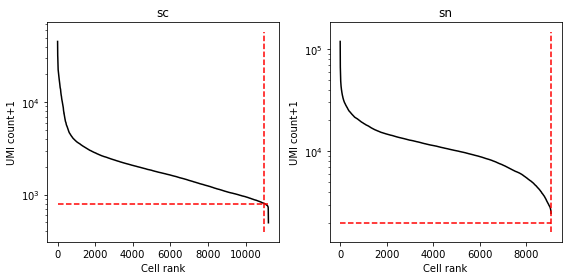

In [55]:
cf = []
thr_lb = [8e2, 2e3]
thr_ub = [1e4, 5e4]

fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

dataset_identifiers = ('C72_RESEQ','C72_TST')
for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k]
    print(filename)
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        print(len(bcs))
        knee_plot(S+U,n_cells,ax1[k],viz=True,thr=thr_lb[k])
        ax1[k].set_title(dataset_meta[k])
        cf_ = ((S+U).sum(0)>thr_lb[k]) & ((S+U).sum(0)<thr_ub[k])
                    
        for cluster in cluster_names:
            cf.append(np.isin(bcs,meta[(meta['sample']==dataset_identifiers[k]) \
                                       & (meta['Manual_Annotation']==cluster)]['cell_barcode'])\
                      & cf_)
fig1.tight_layout()

In [57]:
[x.sum() for x in cf]

[1567, 4421, 991, 2885, 2862, 1879]

## Preprocessing

Identify the genes to fit.

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

In [58]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [ ]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='liver_andrews',batch_id=2,\
                                             n_genes=3000,exp_filter_threshold=None,cf=cf)

## Inference

In [ ]:
dir_string

In [ ]:
dataset_strings

Define parameter bounds, then iterate over datasets and perform the fits.

In [111]:
phys_lb = [-2.0, -1.8, -1.8]
phys_ub = [3.1, 3.5, 3.5]
samp_lb = [1,1]
samp_ub = [1,1]
gridsize = [1,1]
# gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1}
gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':5}

In [ ]:
result_strings_ext = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Extrinsic','None')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = gradient_params)
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings_ext.append(full_result_string)

In [ ]:
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings_ext[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)

#     sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [ ]:

result_strings_burst = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','None')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = gradient_params)
    search_data = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings_burst.append(full_result_string)

In [ ]:
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings_burst[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)

#     sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [ ]:
result_strings_delay = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Delay','None')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = gradient_params)
    search_data = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings_delay.append(full_result_string)

In [ ]:
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings_delay[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)

#     sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [ ]:
result_strings_delayed_splicing = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('DelayedSplicing','None')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = gradient_params)
    search_data = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings_delayed_splicing.append(full_result_string)

In [ ]:
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings_delayed_splicing[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)

#     sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    

In [ ]:
result_strings_ext

In [ ]:
result_strings_burst

In [ ]:
result_strings_delay

In [ ]:
result_strings_delayed_splicing

In [124]:
result_strings_ext=[x[:-4]+'_upd.res' for x in result_strings_ext]
result_strings_burst=[x[:-4]+'_upd.res' for x in result_strings_burst]
result_strings_delay=[x[:-4]+'_upd.res' for x in result_strings_delay]
result_strings_delayed_splicing=[x[:-4]+'_upd.res' for x in result_strings_delayed_splicing]


## Analysis

In [ ]:
sr_arr_full = [[monod.analysis.load_search_results(result_strings_ext[i]),\
                monod.analysis.load_search_results(result_strings_burst[i]),\
                monod.analysis.load_search_results(result_strings_delay[i]),\
                monod.analysis.load_search_results(result_strings_delayed_splicing[i])] for i in range(n_datasets)]

In [ ]:
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]

In [127]:
model_logL = [[sr.get_logL(sd) for sr in x] for x,sd in zip(sr_arr_full,sd_arr)]

In [128]:
model_logL = np.asarray(model_logL)

In [129]:
model_names=('delayed deg.','extrinsic','delayed splic.')

In [ ]:
fig1,ax1=plt.subplots(2,3,figsize=(12,6))
fs=12
alf =0.5
colors = ('goldenrod','mediumseagreen','darkgray')
bw_method=0.05

for model_index,mi in enumerate([[2,1],[0,1],[3,1]]):
    print(model_names[model_index])
    for cluster_index,di in enumerate([[0,3],[1,4],[2,5]]):
        print(cluster_names[cluster_index])
        
        lim = 20
        sc_lr=model_logL[di[0],mi[0]] - model_logL[di[0],1]
        sc_lr = sc_lr[np.abs(sc_lr)<lim]
        sc_kde=scipy.stats.gaussian_kde(sc_lr,bw_method=bw_method)
        x = np.linspace(-lim,lim)
        ax1[0,model_index].plot(x,sc_kde(x),\
                             label=f'{cluster_names[cluster_index]}',color=colors[cluster_index])
        
        lim = 20
        sn_lr=model_logL[di[1],mi[0]] - model_logL[di[1],1]
        sn_lr = sn_lr[np.abs(sn_lr)<lim]
        sn_kde=scipy.stats.gaussian_kde(sn_lr,bw_method=bw_method)
        x = np.linspace(-lim,lim)
        ax1[1,model_index].plot(x,sn_kde(x),\
                             label=f'{cluster_names[cluster_index]}',color=colors[cluster_index])


        print((sc_lr<0).mean())
        print((sn_lr<0).mean())

    for i in range(2):
        yl = ax1[i,model_index].get_ylim()
        ax1[i,model_index].plot([0,0],yl,'k-',linewidth=.5)
        ax1[i,model_index].set_ylim(yl)
    ax1[1,model_index].set_xlabel(fr'$\ln L$({model_names[model_index]}) - $\ln L$(bursty Markovian)',fontsize=fs)
ax1[0,0].set_ylabel('Frequency in whole-cell',fontsize=fs)
ax1[1,0].set_ylabel('Frequency in nuclear',fontsize=fs)
ax1[0,0].legend()
fig1.tight_layout()
plt.savefig('./fig/likelihood_ratio_liver.png',dpi=450)